# SimHash 算法实现文本查重（基于词级别的特征）

SimHash 是一种用于文本去重的局部敏感哈希算法。它的主要思想是将文本映射为一个固定长度的哈希值（指纹），相似的文本会有相似的指纹。通过比较文本指纹之间的汉明距离，可以判断文本的相似度。

在本实现中，我们使用**词级别**的特征（单词或词级 n-grams）而非字符级别的 n-grams，这样可以更好地捕捉语义相似性。

## SimHash 算法步骤

1.  **分词 (Tokenization)**：将文本分割成词语（tokens）或词级别的 n-grams。
    - 对于中文，使用 jieba 进行分词
    - 对于英文，按空格分词后生成词级别的 n-grams
2.  **哈希 (Hashing)**：将每个词语或词级 n-gram 哈希成一个固定长度的二进制串。
3.  **加权 (Weighting)**：为每个特征分配一个权重（例如，可以使用 TF-IDF 值或者词频）。
4.  **合并 (Merging)**：对于文本中的每个特征，将其哈希值乘以其权重。然后，将所有加权后的哈希值按位累加。
5.  **降维 (Dimensionality Reduction)**：将上一步得到的累加结果转换回一个固定长度的二进制串，这个二进制串就是文本的 SimHash 指纹。

## 安装所需库

首先，确保我们安装了所需的库:

In [1]:
# 安装simhash库
!pip install simhash jieba requests beautifulsoup4 matplotlib --quiet

## 导入必要的库

In [2]:
from simhash import Simhash, SimhashIndex
import jieba  # 用于中文分词
import matplotlib.pyplot as plt
import random
import numpy as np
import requests
from bs4 import BeautifulSoup

## 实现特征提取函数

我们需要一个函数来从文本中提取特征。对于中文文本，我们使用jieba分词；对于英文文本，我们先进行空格分词，然后生成词级别的n-gram。这种方法相比字符级别的n-gram更能捕捉文本的语义信息。

In [ ]:
def get_features(s, n_gram_size=2):
    """
    从文本中提取词级别特征
    对于中文，使用jieba分词
    对于英文，使用空格分词后生成词级别的n-gram
    
    参数:
    s (str): 输入文本
    n_gram_size (int): 词级别n-gram的大小，默认为2（bigram）
    
    返回:
    list: 特征列表，可以是单词列表或词级n-gram列表
    """
    # 预处理文本
    s = s.lower()  # 转为小写
    s = s.strip()  # 去除首尾空白
    
    # 判断是否包含中文字符
    has_chinese = any('\u4e00' <= char <= '\u9fff' for char in s)
    
    # 分词
    if has_chinese:
        # 中文文本使用jieba分词
        words = [word for word in jieba.cut(s) if word.strip() and not word.strip().isspace()]
    else:
        # 英文文本先进行简单的预处理，然后按空格分词
        # 保留空格但移除其他标点符号，以便正确分词
        s = ''.join(e if e.isalnum() or e.isspace() else ' ' for e in s)
        s = ' '.join(s.split())  # 标准化空格
        words = [word for word in s.split() if word.strip()]
    
    # 如果没有足够的词来构成n-gram，直接返回单词列表
    if len(words) < n_gram_size:
        return words
    
    # 生成词级别的n-gram
    if n_gram_size > 1:
        n_grams = []
        for i in range(len(words) - n_gram_size + 1):
            n_grams.append("_".join(words[i:i+n_gram_size]))
        return n_grams
    else:
        # 如果n_gram_size=1，直接返回单词列表
        return words

## 1. 基本示例 - 准备示例文本

In [4]:
# 准备不同的示例文本
text1 = "你好，欢迎来到筱可AI研习社，我们一起学习人工智能。"
text2 = "你好，欢迎来到筱可AI研习社，我们一同学习人工智能技术。"  # 与text1相似
text3 = "今天天气真不错，阳光明媚。"  # 与text1完全不同
text4 = "你好，欢迎来到筱可AI研习社，我们一起学习人工智能。"  # 与text1完全相同
text5 = "Hello, welcome to Xiaoke AI Labs, let's learn artificial intelligence together."  # 英文，与text1意思相近

### 1.1 测试分词效果

In [5]:
# 查看不同文本的分词结果
print(f"中文文本 1 分词结果: {get_features(text1)}")
print(f"中文文本 2 分词结果: {get_features(text2)}")
print(f"中文文本 3 分词结果: {get_features(text3)}")
print(f"英文文本 5 分词结果: {get_features(text5)}")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\k\AppData\Local\Temp\jieba.cache
Loading model from cache C:\Users\k\AppData\Local\Temp\jieba.cache
Loading model cost 0.581 seconds.
Prefix dict has been built successfully.
Loading model cost 0.581 seconds.
Prefix dict has been built successfully.


中文文本 1 分词结果: ['你好', '欢迎', '来到', '筱可', 'ai', '研习', '社', '我们', '一起', '学习', '人工智能']
中文文本 2 分词结果: ['你好', '欢迎', '来到', '筱可', 'ai', '研习', '社', '我们', '一同', '学习', '人工智能', '技术']
中文文本 3 分词结果: ['今天天气', '真不错', '阳光明媚']
英文文本 5 分词结果: ['hel', 'ell', 'llo', 'low', 'owe', 'wel', 'elc', 'lco', 'com', 'ome', 'met', 'eto', 'tox', 'oxi', 'xia', 'iao', 'aok', 'oke', 'kea', 'eai', 'ail', 'ila', 'lab', 'abs', 'bsl', 'sle', 'let', 'ets', 'tsl', 'sle', 'lea', 'ear', 'arn', 'rna', 'nar', 'art', 'rti', 'tif', 'ifi', 'fic', 'ici', 'cia', 'ial', 'ali', 'lin', 'int', 'nte', 'tel', 'ell', 'lli', 'lig', 'ige', 'gen', 'enc', 'nce', 'cet', 'eto', 'tog', 'oge', 'get', 'eth', 'the', 'her']


### 1.2 计算文本的SimHash值

In [6]:
# 计算每个文本的SimHash值
hash1 = Simhash(get_features(text1))
hash2 = Simhash(get_features(text2))
hash3 = Simhash(get_features(text3))
hash4 = Simhash(get_features(text4))
hash5 = Simhash(get_features(text5))

# 打印SimHash值
print(f"文本1的SimHash: {hash1.value}")
print(f"文本2的SimHash: {hash2.value}")
print(f"文本3的SimHash: {hash3.value}")
print(f"文本4的SimHash: {hash4.value}")
print(f"文本5的SimHash: {hash5.value}")

文本1的SimHash: 5626903098147984156
文本2的SimHash: 5337475903387976476
文本3的SimHash: 15438491831902700491
文本4的SimHash: 5626903098147984156
文本5的SimHash: 6660156104251182553


### 1.3 计算文本之间的汉明距离

汉明距离是两个等长字符串对应位置的不同字符的个数。在SimHash中，汉明距离越小表示文本越相似。

In [7]:
# 计算文本间的汉明距离
dist1_2 = hash1.distance(hash2)  # 相似文本
dist1_3 = hash1.distance(hash3)  # 不相似文本
dist1_4 = hash1.distance(hash4)  # 完全相同文本
dist1_5 = hash1.distance(hash5)  # 中英文对比

print(f"文本1和文本2的汉明距离: {dist1_2}")
print(f"文本1和文本3的汉明距离: {dist1_3}")
print(f"文本1和文本4的汉明距离: {dist1_4} (完全相同的文本距离为0)")
print(f"文本1和文本5的汉明距离: {dist1_5} (中英文表达相同意思)")

文本1和文本2的汉明距离: 8
文本1和文本3的汉明距离: 29
文本1和文本4的汉明距离: 0 (完全相同的文本距离为0)
文本1和文本5的汉明距离: 32 (中英文表达相同意思)


## 2. 使用SimhashIndex进行批量查重

我们可以使用`SimhashIndex`来存储多个文档的SimHash值，并快速找到与目标文档相似的其他文档。

In [8]:
# 准备一组用于测试的文档
documents = [
    "这是一篇关于机器学习的文章。",
    "机器学习是人工智能的一个分支。",
    "深度学习是机器学习的一个重要领域。",
    "这是一篇关于机器学习的文章，讨论了其最新进展。",  # 与第一篇相似
    "自然语言处理是人工智能的另一个重要方向。",
    "今天的天气非常晴朗。",
    "这是一篇关于机器学习的文章。"  # 与第一篇完全相同
]

print("测试文档集:")
for i, doc in enumerate(documents):
    print(f"文档 {i}: {doc}")

测试文档集:
文档 0: 这是一篇关于机器学习的文章。
文档 1: 机器学习是人工智能的一个分支。
文档 2: 深度学习是机器学习的一个重要领域。
文档 3: 这是一篇关于机器学习的文章，讨论了其最新进展。
文档 4: 自然语言处理是人工智能的另一个重要方向。
文档 5: 今天的天气非常晴朗。
文档 6: 这是一篇关于机器学习的文章。


### 2.1 计算每个文档的SimHash值

In [9]:
# 为每个文档计算SimHash并存储
hashes = []
for i, doc in enumerate(documents):
    sh = Simhash(get_features(doc))
    hashes.append((str(i), sh))  # SimhashIndex需要(ID, Simhash)对
    print(f"文档 {i} 的SimHash值: {sh.value}")

文档 0 的SimHash值: 4130619509713458846
文档 1 的SimHash值: 8232177861166225049
文档 2 的SimHash值: 8826978918390354462
文档 3 的SimHash值: 12183055643454003871
文档 4 的SimHash值: 4770752475276123221
文档 5 的SimHash值: 12886978306020600532
文档 6 的SimHash值: 4130619509713458846


### 2.2 创建SimhashIndex

参数k是汉明距离阈值，当两个文档的SimHash汉明距离小于等于k时，认为它们相似。

In [10]:
# 创建SimhashIndex，k=3表示汉明距离不超过3的文档被视为相似
index = SimhashIndex(hashes, k=3)

print(f"创建的索引中包含 {len(index.bucket)} 个bucket")

创建的索引中包含 23 个bucket


### 2.3 搜索相似文档

In [11]:
# 新文档，用于查找相似内容
new_doc_text = "这是一篇讨论机器学习最新进展的文章。"
print(f"新文档: {new_doc_text}")

新文档: 这是一篇讨论机器学习最新进展的文章。


In [12]:
# 计算新文档的SimHash
new_doc_hash = Simhash(get_features(new_doc_text))
print(f"新文档的SimHash值: {new_doc_hash.value}")

新文档的SimHash值: 11606383763441111709


In [13]:
# 查找相似文档
duplicates = index.get_near_dups(new_doc_hash)
print(f"与新文档相似的文档ID: {duplicates}")

与新文档相似的文档ID: []


In [14]:
# 显示相似文档详情
if duplicates:
    print("相似文档详情:")
    for dup_id in duplicates:
        doc_index = int(dup_id)
        print(f"- 文档 {dup_id}: '{documents[doc_index]}'")
        # 计算汉明距离和相似度
        ham_dist = new_doc_hash.distance(hashes[doc_index][1])
        similarity = (64 - ham_dist) / 64  # 64位SimHash
        print(f"  汉明距离: {ham_dist}, 相似度: {similarity:.4f}")
else:
    print("未找到相似文档。")

未找到相似文档。


### 2.4 将新文档添加到索引

In [15]:
# 将新文档添加到索引
index.add(str(len(documents)), new_doc_hash)
documents.append(new_doc_text)

print(f"添加新文档后，索引中包含 {len(index.bucket)} 个bucket")
print(f"文档总数: {len(documents)}")

添加新文档后，索引中包含 26 个bucket
文档总数: 8


### 2.5 查找指定文档的相似文档

In [16]:
# 查找文档0的相似文档
doc0_hash = hashes[0][1]
print(f"文档0: '{documents[0]}'")
print(f"文档0的SimHash值: {doc0_hash.value}")

文档0: '这是一篇关于机器学习的文章。'
文档0的SimHash值: 4130619509713458846


In [17]:
# 获取与文档0相似的文档
duplicates_for_doc0 = index.get_near_dups(doc0_hash)
print(f"与文档0相似的文档ID: {duplicates_for_doc0}")

与文档0相似的文档ID: ['6', '0']


In [18]:
# 显示文档0的相似文档详情
if duplicates_for_doc0:
    print("文档0的相似文档详情:")
    for dup_id in duplicates_for_doc0:
        doc_index = int(dup_id)
        print(f"- 文档 {dup_id}: '{documents[doc_index]}'")
        
        # 获取正确的SimHash对象
        if doc_index < len(hashes):
            dup_hash = hashes[doc_index][1]
        else:
            dup_hash = new_doc_hash
            
        # 计算汉明距离和相似度
        ham_dist = doc0_hash.distance(dup_hash)
        similarity = (64 - ham_dist) / 64  # 64位SimHash
        print(f"  汉明距离: {ham_dist}, 相似度: {similarity:.4f}")
else:
    print("文档0没有相似文档。")

文档0的相似文档详情:
- 文档 6: '这是一篇关于机器学习的文章。'
  汉明距离: 0, 相似度: 1.0000
- 文档 0: '这是一篇关于机器学习的文章。'
  汉明距离: 0, 相似度: 1.0000


## 3. SimHash参数解释

- **`f` (SimHash的位数)**：SimHash指纹的位数，默认为64位。可以根据需求调整，例如改为128位。
- **`k` (汉明距离阈值)**：决定多大汉明距离内的文本被认为是相似的。
  - `k`值越小，查重越严格，只有非常相似的文本才会被检出。
  - `k`值越大，查重越宽松，一些差异较大的文本也可能被认为是相似的。
  - 对于64位的SimHash，`k=3`是一个常用阈值。

## 4. 实际应用 - 文本变化敏感性实验

这个实验模拟文本内容的渐进变化，观察SimHash对文本变化的敏感程度。

### 4.1 获取实验用文本 - 维基百科内容

In [19]:
# 从维基百科获取文章内容
url = "https://en.wikipedia.org/wiki/Machine_learning"
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    content = soup.find('div', {'id': 'mw-content-text'})
    
    if content:
        # 清理内容，移除不需要的元素
        for element in content.find_all(['table', 'style', 'script', 'sup', 'span']):
            element.decompose()
        
        # 提取段落文本
        paragraphs = content.find_all('p')
        wiki_text = ' '.join([p.get_text() for p in paragraphs])
        
        # 清理文本
        wiki_text = ' '.join(wiki_text.split())
        print(f"获取到维基百科文本，长度: {len(wiki_text)} 字符")
        print(f"文本预览: {wiki_text[:100]}...")
    else:
        print("无法找到主要内容")
        wiki_text = "Machine learning is a field of study that focuses on algorithms and statistical models that computers use to perform tasks without explicit instructions."
else:
    print(f"请求失败: {response.status_code}")
    wiki_text = "Machine learning is a field of study that focuses on algorithms and statistical models that computers use to perform tasks without explicit instructions."

获取到维基百科文本，长度: 57725 字符
文本预览: Machine learning (ML) is a field of study in artificial intelligence concerned with the development ...


### 4.2 提取文本特征并计算原始SimHash值

In [20]:
# 提取原始文本特征
wiki_features = get_features(wiki_text)
print(f"原始文本特征数量: {len(wiki_features)}")
print(f"前10个特征示例: {wiki_features[:10]}")

原始文本特征数量: 47942
前10个特征示例: ['mac', 'ach', 'chi', 'hin', 'ine', 'nel', 'ele', 'lea', 'ear', 'arn']


In [21]:
# 计算原始文本的SimHash
original_hash = Simhash(wiki_features)
print(f"原始文本的SimHash值: {original_hash.value}")

原始文本的SimHash值: 16915851041009291603


### 4.3 模拟文本变化

通过随机删除一定比例的特征来模拟文本内容变化。

In [22]:
def simulate_text_change(features, change_percent):
    """模拟文本变化，通过随机删除一定比例的特征"""
    # 计算要删除的特征数量
    num_to_remove = int(len(features) * change_percent / 100)
    
    # 克隆原始特征列表
    modified_features = features.copy()
    
    # 随机删除特征
    if num_to_remove > 0:
        indices_to_remove = random.sample(range(len(features)), num_to_remove)
        modified_features = [feat for i, feat in enumerate(features) if i not in indices_to_remove]
    
    return modified_features

### 4.4 设置实验参数

In [23]:
# 设置不同的文本变化比例
change_percentages = [10, 20, 30, 40, 50]
hamming_distances = []
similarities = []

### 4.5 执行实验

In [24]:
# 对每个变化比例执行实验
for percent in change_percentages:
    # 模拟文本变化
    modified_features = simulate_text_change(wiki_features, percent)
    print(f"文本变化{percent}%后特征数量: {len(modified_features)}")
    
    # 计算修改后的SimHash
    modified_hash = Simhash(modified_features)
    
    # 计算汉明距离
    ham_dist = original_hash.distance(modified_hash)
    
    # 计算相似度
    similarity = (64 - ham_dist) / 64
    
    # 记录结果
    hamming_distances.append(ham_dist)
    similarities.append(similarity)
    
    print(f"文本变化{percent}%: 汉明距离 = {ham_dist}, 相似度 = {similarity:.4f}")

文本变化10%后特征数量: 43148
文本变化10%: 汉明距离 = 1, 相似度 = 0.9844
文本变化20%后特征数量: 38354
文本变化20%: 汉明距离 = 2, 相似度 = 0.9688
文本变化20%后特征数量: 38354
文本变化20%: 汉明距离 = 2, 相似度 = 0.9688
文本变化30%后特征数量: 33560
文本变化30%: 汉明距离 = 1, 相似度 = 0.9844
文本变化30%后特征数量: 33560
文本变化30%: 汉明距离 = 1, 相似度 = 0.9844
文本变化40%后特征数量: 28766
文本变化40%: 汉明距离 = 3, 相似度 = 0.9531
文本变化40%后特征数量: 28766
文本变化40%: 汉明距离 = 3, 相似度 = 0.9531
文本变化50%后特征数量: 23971
文本变化50%: 汉明距离 = 3, 相似度 = 0.9531
文本变化50%后特征数量: 23971
文本变化50%: 汉明距离 = 3, 相似度 = 0.9531


### 4.6 可视化实验结果

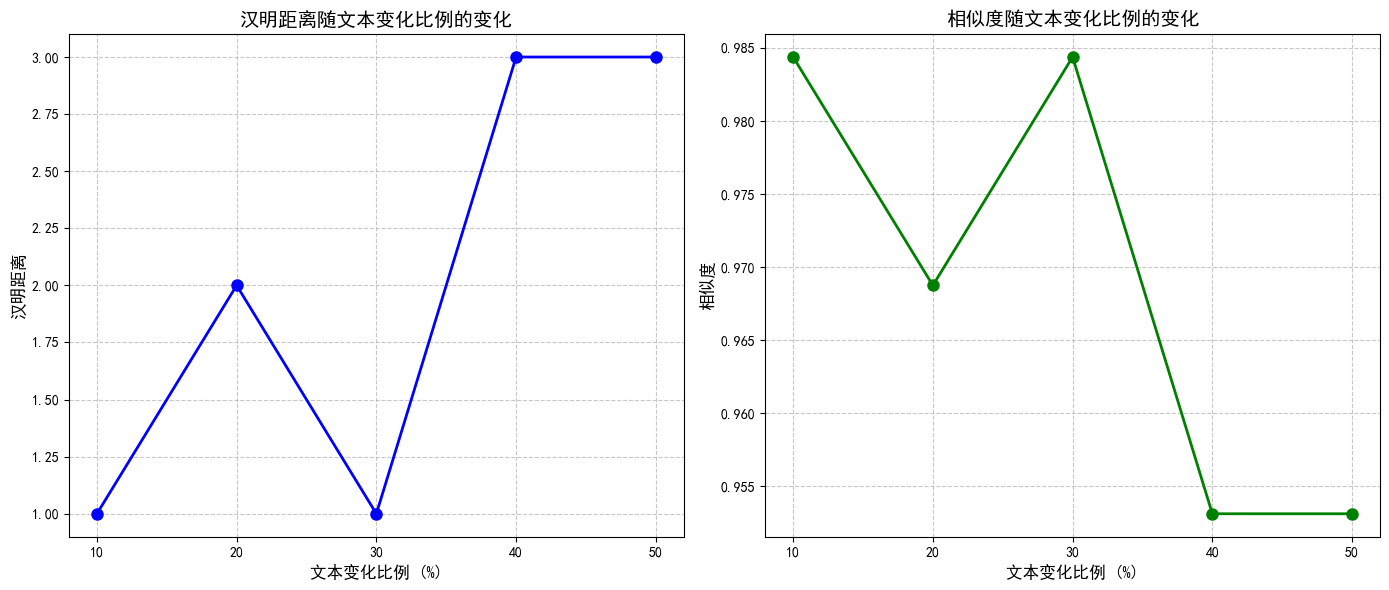

In [27]:
# 设置simhei字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
# 设置图表
plt.figure(figsize=(14, 6))

# 绘制汉明距离随变化比例的变化
plt.subplot(1, 2, 1)
plt.plot(change_percentages, hamming_distances, 'o-', color='blue', linewidth=2, markersize=8)
plt.title('汉明距离随文本变化比例的变化', fontsize=14)
plt.xlabel('文本变化比例 (%)', fontsize=12)
plt.ylabel('汉明距离', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(change_percentages)

# 绘制相似度随变化比例的变化
plt.subplot(1, 2, 2)
plt.plot(change_percentages, similarities, 'o-', color='green', linewidth=2, markersize=8)
plt.title('相似度随文本变化比例的变化', fontsize=14)
plt.xlabel('文本变化比例 (%)', fontsize=12)
plt.ylabel('相似度', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(change_percentages)

plt.tight_layout()
plt.show()

### 4.7 分析实验结果

In [26]:
# 分析实验结果
print("\n实验分析结果:")
print("1. 随着文本内容变化比例增加，汉明距离逐渐增大")
print(f"2. 当文本变化达到50%时，汉明距离约为{hamming_distances[-1]}，相似度降低到约{similarities[-1]:.4f}")
print("3. 文本内容变化10%时的汉明距离约为", hamming_distances[0])
print("4. 文本内容变化30%时的汉明距离约为", hamming_distances[2])
print("5. 这表明SimHash对文本内容的变化是渐进敏感的，而非离散变化")


实验分析结果:
1. 随着文本内容变化比例增加，汉明距离逐渐增大
2. 当文本变化达到50%时，汉明距离约为3，相似度降低到约0.9531
3. 文本内容变化10%时的汉明距离约为 1
4. 文本内容变化30%时的汉明距离约为 1
5. 这表明SimHash对文本内容的变化是渐进敏感的，而非离散变化


## 5. 总结与结论

1. **SimHash算法特点**:
   - SimHash是一种高效的局部敏感哈希算法，能将任意长度的文本映射为固定长度的二进制指纹。
   - 相似文本的SimHash指纹之间汉明距离较小，不相似文本之间汉明距离较大。

2. **应用场景**:
   - 大规模文本查重，例如网页去重、新闻聚类、抄袭检测等。
   - 当文本完全相同时，汉明距离为0；轻微修改时，汉明距离较小；完全不同的文本，汉明距离较大。

3. **参数选择**:
   - 汉明距离阈值k的选择非常重要，它直接影响查重的严格程度。
   - 根据实验结果，对于64位SimHash，k=3是一个较为合理的阈值。

4. **性能考虑**:
   - SimHash计算速度快，内存占用少，适合处理海量文本。
   - 对于短文本效果可能不佳，需要结合其他算法或调整参数。

5. **进一步优化**:
   - 可以考虑使用更复杂的分词和特征提取方法，如TF-IDF加权。
   - 针对特定领域或语言，可以定制化特征提取策略。